# MNIST Digit Classification

There are several other versions of the MNIST digits classification. This endeavour focuses on a CNN based approach.

In [1]:
import torch
import torch.nn as nn

import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt

import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

image_path = './'
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=True)

# Save 10000 for validation and leave the rest for training
# valid_data = Subset(mnist_dataset, torch.arange(10000))
# train_data = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
train_data, valid_data = random_split(mnist_dataset, [50000, 10000], generator=torch.Generator().manual_seed(42))

test_data = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=True)

In [3]:
batch_size = 64
torch.manual_seed(42)

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [4]:
# For the CNN architechture, we will have a few sparse convolutional layers at the start
# with pooling in between.
# Then end in 2 fully connected layers to train on the post-convolutional features
# with dropout layers

model = nn.Sequential()

# Add the first convolutional layer
# In PyTorch, the input is assumed to be the NCHW format - N: number of images, C: number of channels
# H: Height, W: Width (Tensorflow assumes an NHWC format)
# The kernel size is the dimension of the convolutional filter. We can also set the padding size (defualts to 0), as well as the stride (defaults to 1)
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
# Activation
model.add_module('relu1', nn.ReLU())
# Pooling layer - Opt for a Max Pooling with a kernel_size of 2
# stride can be set here to match the pooling consistently as well
model.add_module('pool1', nn.MaxPool2d(kernel_size=2)) # The pooling window is 2 x 2, so the H, W are reduced by a factor of 2 for each channel
# Second convolutional layer
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
# Second activation
model.add_module('relu2', nn.ReLU())
# Second pooling
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

# Now we start moving onto the fully connected layers

# We can manually compute the output dimension of the convolutional feature map. An easier way is to just pass an argument into it
one_input = torch.ones((64, 1, 28, 28)) # Images are in batches of 64, with 1 channel (grayscale) and are 28 x 28 in H, W
print(model(one_input).shape)

# To pass it into a fully connected layer, we need to flatten it to batch_size x input_units
model.add_module('flatten', nn.Flatten())
print(model(one_input).shape)

torch.Size([64, 64, 7, 7])
torch.Size([64, 3136])


In [5]:
# Now we can add in the fully connected layers
# Fully Connected Layer 1
model.add_module('fc1', nn.Linear(3136, 1024))
# Activation 1
model.add_module('relu3', nn.ReLU())
# Dropout Layer with p_{drop} = 0.5
model.add_module('dropout', nn.Dropout(p=0.5))
# Fully Connected Layer 2
model.add_module('fc2', nn.Linear(1024, 10))


# Now define the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist = {}
    loss_hist['train'] = [0] * num_epochs
    loss_hist['valid'] = [0] * num_epochs

    acc_hist = {}
    acc_hist['train'] = [0] * num_epochs
    acc_hist['valid'] = [0] * num_epochs

    for epoch in range(num_epochs):
        # Set the model to training mode, where the dropout is active
        model.train()

        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_func(pred, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist['train'][epoch] += loss.item() * y_batch.size(0)
            correct_preds = (torch.argmax(pred, dim=1) == y_batch).float()
            acc_hist['train'][epoch] += correct_preds.sum()
        
        loss_hist['train'][epoch] /= len(train_dl.dataset)
        acc_hist['train'][epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_func(pred, y_batch)

                loss_hist['valid'][epoch] += loss.item() * y_batch.size(0)
                correct_preds = (torch.argmax(pred, dim=1) == y_batch).float()
                acc_hist['valid'][epoch] += correct_preds.sum()

        loss_hist['valid'][epoch] /= len(valid_dl.dataset)
        acc_hist['valid'][epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch + 1}\nTraining accuracy: {acc_hist['train'][epoch]:.4f}')
        print(f'Validation accuracy: {acc_hist['valid'][epoch]:.4f}')
    
    return loss_hist['train'], loss_hist['valid'], acc_hist['train'], acc_hist['valid']

In [7]:
torch.manual_seed(42)
num_epochs = 20

hist = train(model=model, num_epochs=num_epochs, train_dl=train_dl, valid_dl=valid_dl)

Epoch 1
Training accuracy: 0.9493
Validation accuracy: 0.9851
Epoch 2
Training accuracy: 0.9844
Validation accuracy: 0.9874
Epoch 3
Training accuracy: 0.9896
Validation accuracy: 0.9883
Epoch 4
Training accuracy: 0.9917
Validation accuracy: 0.9896
Epoch 5
Training accuracy: 0.9932
Validation accuracy: 0.9899
Epoch 6
Training accuracy: 0.9943
Validation accuracy: 0.9899
Epoch 7
Training accuracy: 0.9954
Validation accuracy: 0.9903
Epoch 8
Training accuracy: 0.9964
Validation accuracy: 0.9906
Epoch 9
Training accuracy: 0.9964
Validation accuracy: 0.9902
Epoch 10
Training accuracy: 0.9971
Validation accuracy: 0.9888
Epoch 11
Training accuracy: 0.9965
Validation accuracy: 0.9894
Epoch 12
Training accuracy: 0.9975
Validation accuracy: 0.9907
Epoch 13
Training accuracy: 0.9968
Validation accuracy: 0.9907
Epoch 14
Training accuracy: 0.9980
Validation accuracy: 0.9923
Epoch 15
Training accuracy: 0.9977
Validation accuracy: 0.9905
Epoch 16
Training accuracy: 0.9978
Validation accuracy: 0.9908
E

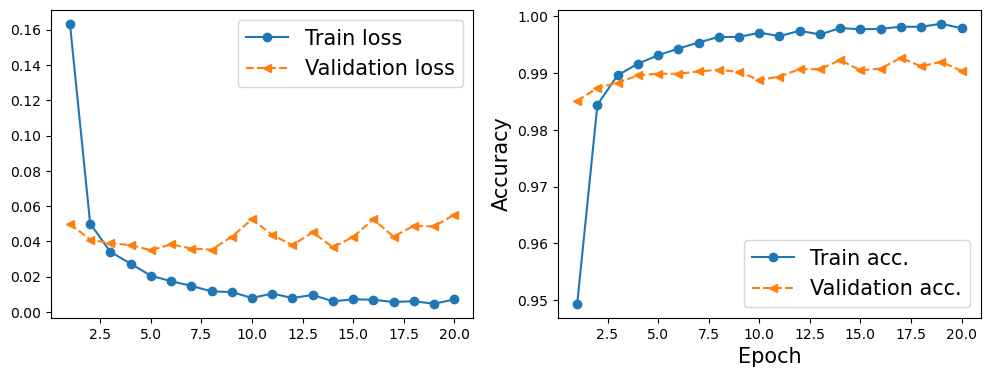

In [8]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [11]:
pred = model(test_data.data.unsqueeze(1) / 255.)
correct_preds = (torch.argmax(pred, dim=1) == test_data.targets).float()
print(f'Test accuracy: {correct_preds.mean():.4f}')

Test accuracy: 0.9936


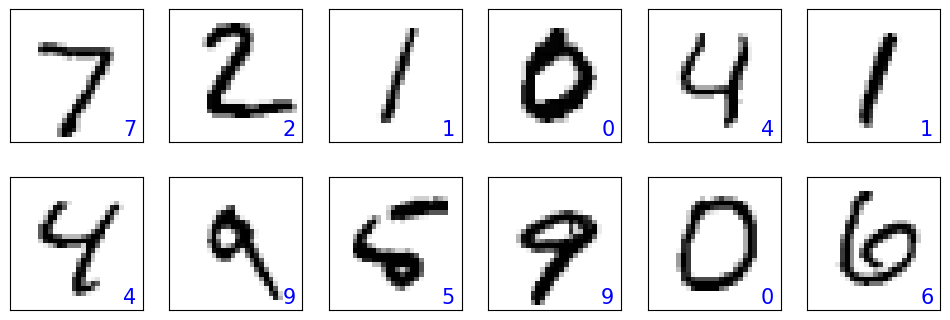

In [13]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = test_data[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), size=15, color='blue', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()